# CatBoost - Category Boosting
- Kategorik değişkenler ile otomatik mücadele edebilen, hızlı, başarılı bir diğer GBM türevidir.
- Hızlı ve ölçeklenebilir GPU desteği sağlamaktadır.
- Daha başarılı tahminler yapıldığı iddaa etmektedir.
- Hızlı train ve hızlı tahmin işlemleri yapıldığı iddia edilmektedir.

In [1]:
!pip install catboost

**Gerekli Kütüphaneler** 

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import scale, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

In [7]:
# Uyarı Mesajları ile Karşılaşmamak için bu kütüphaneyi kullanıyoruz.
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)

# Veri Seti Hikayesi ve Problemi: Şeker Hastalığı Tahmini

In [8]:
df = pd.read_csv("./diabetes.csv")
# bu csv dosyasının içerisinde eksik gözlemleri(NA) çıkardık.
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# CatBoost ve Tahmin İşlemleri

In [9]:
y= df["Outcome"]
X = df.drop(["Outcome"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.30,
                                                    random_state = 42)

**Model**

In [23]:
catb_model = CatBoostClassifier().fit(X_train, y_train,verbose= False)

In [24]:
?catb_model

Type:            CatBoostClassifier
String form:     <catboost.core.CatBoostClassifier object at 0x0000019ABF154610>
File:            c:\users\halil\anaconda3\lib\site-packages\catboost\core.py
Docstring:       <no docstring>
Class docstring: CatBoost model. Contains training, prediction and evaluation methods.
Init docstring: 
Initialize the CatBoost.

Parameters
----------
params : dict
    Parameters for CatBoost.
    If  None, all params are set to their defaults.
    If  dict, overriding parameters present in dict.


**Tahmin**

In [25]:
y_pred = catb_model.predict(X_test)

In [26]:
accuracy_score(y_test,y_pred)

0.7402597402597403

# Model Tuning (Model Doğrulama)
-  Modelin başarısını değerlendirmek için izlenecek yol Doğruluk oranına (accuracy_score) bakılarak yapılacak. 
- **accuracy_score**' u ne kadar büyük olursa sınıflandırma da o kadar başarılı olduğu anlamına gelir.
- Hiper parametrelerin optimum değerlerine ulaşmak içinde Cross-Validation yöntemini kullanmış olacağız.
- Yani modelleri Train Setiyle eğitirken Cross-Validation yönetemini kullanıp, dışarı bıraktığımız Test Setini ise performansımızı test etmek için kullanacaz.

In [16]:
catb_params = {"iterations": [200,500,1000],
              "learning_rate":[0.01,0.1],
              "depth": [3,6,8]
              }

In [20]:
catb_cv_model = GridSearchCV(catb_model,catb_params,cv=5,n_jobs=-1,verbose=2).fit(X_train,y_train, verbose=False)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


In [28]:
catb_cv_model.best_params_

{'depth': 8, 'iterations': 200, 'learning_rate': 0.01}

**Final Modeli**

In [29]:
catb_tuned = CatBoostClassifier(iterations=200,
                                learning_rate=0.01,
                                depth=8).fit(X_train,y_train, verbose=False)

In [31]:
y_tuned_pred = catb_tuned.predict(X_test)

In [32]:
accuracy_score(y_test,y_tuned_pred)

0.7532467532467533

## Değişken Önem Düzeyleri

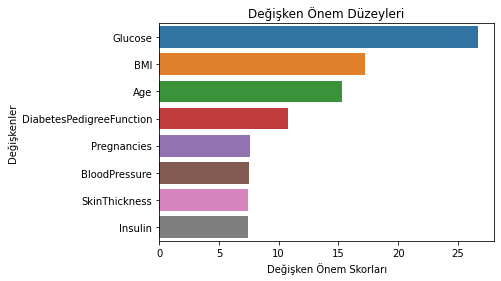

In [33]:
feature_imp = pd.Series(catb_tuned.feature_importances_,
                        index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel("Değişken Önem Skorları")
plt.ylabel("Değişkenler")
plt.title("Değişken Önem Düzeyleri")
plt.savefig("Değişken Önem Düzeyleri")
plt.show()